# Intraday ETF Trading Strategy

The goal of this project is to create a long only trading strategy combining intraday NAV values and high frequency metrics. This project was done in collaboration with Anthony Puffenbarger, Cole Stecyk, and Kelvin Wang.

Observations are grouped by market environment. Here is how market environment is defined:

  * If Order imbalance is positive and flow over the past 5 minutes is positive, the environment is **Bullish**
  
  * If Order imbalance is positive but flow over the past 5 minutes is negative, the environment is **Bullish Future**
  
  * If Order imbalance is negative but flow over the past 5 minutes is positive, the environment is **Negative Future**
  
  * If Order imbalance is negative and flow over the past 5 minutes is negative, the environment is **Negative**

I am fitting separate robust linear models to each market environment but using the same variables. The variables are:

  * NAV Discount Bid
  * Order Imbalance
  * 5 Minute flow
  * NAV Discount * 5 minute flow
  * Order Imbalance * $\frac{bid-ask~spread}{price}$

In [1]:
library(lmtest)
library(MASS)
library(sfsmisc)
library(tidyverse)
library(lubridate)
library(corrr)
library(knitr)
library(PerformanceAnalytics)
library(xts)
library(Quandl)
library(fst)
Quandl.api_key(Sys.getenv('QUANDL_KEY'))


rlm_summary <- function(rlm_mod){
  mod_sum <- summary(rlm_mod)
  
  `p value` <- c()
  for(var in names(rlm_mod$coefficients)){
    `p value` <- c(`p value`,f.robftest(rlm_mod,var = var)$p.value)
  }
  
  mod_sum[['coefficients']] <- cbind(mod_sum[['coefficients']],`p value`)
  
  return(mod_sum)
  
}

basic_equation <- formula(vwap_fwd_rtn_5min_10s_vwap ~ 
                          mkt_env*(nav_discount_bid + order_imbalance*bid_ask_price_5min + nav_discount_bid*flow_5min))

benchmark_prices <- Quandl.datatable('QUOTEMEDIA/PRICES', ticker=c('HYG','JNK','BKLN','SRLN','PFF','PGX','SPHY'),paginate=TRUE) %>%
  filter((date >= as.Date('2020-12-31'))&(date <= as.Date('2021-12-31'))) %>%
  select(date, ticker, adj_close) %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = adj_close)

etf.xts <- xts(benchmark_prices[,-1], order.by = benchmark_prices$date)

fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }
fig(12,8)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.4     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"package 'readr' was built under R version 4.1.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::last()   masks sfsmisc::last()
x dplyr::select() masks MASS::select()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: xts


Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last


The following object is masked from 'package:sfsmisc':

    las

Observations are grouped by market environment. Here is how market environment is defined:

  * If Order imbalance is positive and flow over the past 5 minutes is positive, the environment is **Bullish**
  
  * If Order imbalance is positive but flow over the past 5 minutes is negative, the environment is **Bullish Future**
  
  * If Order imbalance is negative but flow over the past 5 minutes is positive, the environment is **Negative Future**
  
  * If Order imbalance is negative and flow over the past 5 minutes is negative, the environment is **Negative**

I am fitting separate models to each market environment but using the same variables. The variables are:

  * NAV Discount Bid
  * Order Imbalance
  * 5 Minute flow
  * NAV Discount * 5 minute flow
  * Order Imbalance * $\frac{bid-ask~spread}{price}$

In [2]:
etf_metrics <- read.fst('etf_metrics.fst') %>%
  select(date, ticker, vwap_fwd_rtn_5min_10s_vwap, order_imbalance, order_imbalance_1min,
         bid_ask_price_5min, nav_discount_bid, flow_5min, fwd_vwap_10s, fwd_volume_10s, NBB, NBO, NBOqty, NBBqty) %>%
  filter(hour(date)<15|((hour(date)==15)&(minute(date)<=55))) %>%
  drop_na()

vol_pct <- 0.1

etf_metrics <- etf_metrics %>% 
  arrange(date) %>% 
  group_by(ticker)  %>%
  mutate(sell_price = ifelse(is.na(fwd_vwap_10s),NBB,fwd_vwap_10s),
         sell_qty = ifelse(fwd_volume_10s==0,NBBqty,fwd_volume_10s*vol_pct),
         buy_price = ifelse(is.na(fwd_vwap_10s),NBO,fwd_vwap_10s),
         buy_qty = ifelse(fwd_volume_10s==0,NBOqty,fwd_volume_10s*vol_pct),
         transaction_qty = ifelse(buy_qty > lead(sell_qty,1),lead(sell_qty,1),buy_qty),
         buy_size = transaction_qty * buy_price) %>%
  ungroup()


etf_metrics[etf_metrics$order_imbalance >= 0 & etf_metrics$flow_5min >= 0,'mkt_env']='bullish'
etf_metrics[etf_metrics$order_imbalance >= 0 & etf_metrics$flow_5min < 0,'mkt_env']='bullish future'
etf_metrics[etf_metrics$order_imbalance < 0 & etf_metrics$flow_5min >= 0,'mkt_env']='bearish future'
etf_metrics[etf_metrics$order_imbalance < 0 & etf_metrics$flow_5min < 0,'mkt_env']='bearish'

etf_train <- etf_metrics %>% filter(year(date) < 2021)
etf_test <- etf_metrics %>% filter(year(date) == 2021)

## ETF Models

### HYG

In [3]:
hyg_train <- etf_train %>% filter(ticker=='HYG')
hyg_test <- etf_test %>% filter(ticker=='HYG')

hyg_mm <- rlm(basic_equation, data = hyg_train, method = 'MM', scale.est='MAD', maxit=1000)

hyg_strat_rtns <- tibble(date = hyg_test$date,
                  actual = hyg_test$vwap_fwd_rtn_5min_10s_vwap,
                  mm_pred = predict(hyg_mm, newdata = hyg_test)) %>%
  mutate(mm_signal = mm_pred>0,
         mm_rtn = actual*mm_signal) %>%
  rename(HYG_MM=mm_rtn) %>%
  select(date, HYG_MM)

hyg.strat.rtns <- xts(hyg_strat_rtns[,-1],order.by = hyg_strat_rtns$date)

hyg.strat.daily.rtns <- apply.daily(hyg.strat.rtns,Return.cumulative)
index(hyg.strat.daily.rtns) <- as.Date(index(hyg.strat.daily.rtns))

HYG.rtns <- Return.calculate(etf.xts$HYG)
hyg.xts <- merge.xts(hyg.strat.daily.rtns,HYG.rtns)[-1,]

CumRtn <- Return.cumulative(hyg.xts)
calmar <- CalmarRatio(hyg.xts, scale = 252)
sharpe <- SharpeRatio(hyg.xts, scale = 252, annualize = TRUE, FUN = 'StdDev')
sortino <- SortinoRatio(hyg.xts, scale = 252)
max.drawdown <- maxDrawdown(hyg.xts)
hyg.performance.stats <- rbind.data.frame(CumRtn, calmar, sharpe, sortino, max.drawdown)

### JNK

In [4]:
jnk_train <- etf_train %>% filter(ticker=='JNK')
jnk_test <- etf_test %>% filter(ticker=='JNK')

jnk_mm <- rlm(basic_equation, data = jnk_train, method = 'MM', scale.est='MAD', maxit=1000)

jnk_strat_rtns <- tibble(date = jnk_test$date,
                  actual = jnk_test$vwap_fwd_rtn_5min_10s_vwap,
                  mm_pred = predict(jnk_mm, newdata = jnk_test)) %>%
  mutate(mm_signal = mm_pred>0,
         mm_rtn = actual*mm_signal) %>%
  rename(JNK_MM=mm_rtn) %>%
  select(date, JNK_MM)

jnk.strat.rtns <- xts(jnk_strat_rtns[,-1],order.by = jnk_strat_rtns$date)

jnk.strat.daily.rtns <- apply.daily(jnk.strat.rtns, Return.cumulative)
index(jnk.strat.daily.rtns) <- as.Date(index(jnk.strat.daily.rtns))

JNK.rtns <- Return.calculate(etf.xts$JNK)
jnk.xts <- merge.xts(jnk.strat.daily.rtns, JNK.rtns)[-1,]

CumRtn <- Return.cumulative(jnk.xts)
calmar <- CalmarRatio(jnk.xts, scale = 252)
sharpe <- SharpeRatio(jnk.xts, scale = 252, annualize = TRUE, FUN = 'StdDev')
sortino <- SortinoRatio(jnk.xts, scale = 252)
max.drawdown <- maxDrawdown(jnk.xts)
jnk.performance.stats <- rbind.data.frame(CumRtn, calmar, sharpe, sortino, max.drawdown)

### BKLN

In [5]:
bkln_train <- etf_train %>% filter(ticker=='BKLN')
bkln_test <- etf_test %>% filter(ticker=='BKLN')

bkln_mm <- rlm(basic_equation, data = bkln_train, method = 'MM', scale.est='MAD', maxit=1000)

bkln_strat_rtns <- tibble(date = bkln_test$date,
                  actual = bkln_test$vwap_fwd_rtn_5min_10s_vwap,
                  mm_pred = predict(bkln_mm, newdata = bkln_test)) %>%
  mutate(mm_signal = mm_pred>0,
         mm_rtn = actual*mm_signal) %>%
  rename(BKLN_MM=mm_rtn) %>%
  select(date, BKLN_MM)

bkln.strat.rtns <- xts(bkln_strat_rtns[,-1],order.by = bkln_strat_rtns$date)

bkln.strat.daily.rtns <- apply.daily(bkln.strat.rtns,Return.cumulative)
index(bkln.strat.daily.rtns) <- as.Date(index(bkln.strat.daily.rtns))

BKLN.rtns <- Return.calculate(etf.xts$BKLN)
bkln.xts <- merge.xts(bkln.strat.daily.rtns,BKLN.rtns)[-1,]

CumRtn <- Return.cumulative(bkln.xts)
calmar <- CalmarRatio(bkln.xts, scale = 252)
sharpe <- SharpeRatio(bkln.xts, scale = 252, annualize = TRUE, FUN = 'StdDev')
sortino <- SortinoRatio(bkln.xts, scale = 252)
max.drawdown <- maxDrawdown(bkln.xts)
bkln.performance.stats <- rbind.data.frame(CumRtn, calmar, sharpe, sortino, max.drawdown)

### SRLN

In [6]:
srln_train <- etf_train %>% filter(ticker=='SRLN')
srln_test <- etf_test %>% filter(ticker=='SRLN')

srln_mm <- rlm(basic_equation, data = srln_train, method = 'MM', scale.est='MAD', maxit=1000)

srln_strat_rtns <- tibble(date = srln_test$date,
                  actual = srln_test$vwap_fwd_rtn_5min_10s_vwap,
                  mm_pred = predict(srln_mm, newdata = srln_test)) %>%
  mutate(mm_signal = mm_pred>0,
         mm_rtn = actual*mm_signal) %>%
  rename(SRLN_MM=mm_rtn) %>%
  select(date, SRLN_MM)

srln.strat.rtns <- xts(srln_strat_rtns[,-1],order.by = srln_strat_rtns$date)

srln.strat.daily.rtns <- apply.daily(srln.strat.rtns,Return.cumulative)
index(srln.strat.daily.rtns) <- as.Date(index(srln.strat.daily.rtns))

SRLN.rtns <- Return.calculate(etf.xts$SRLN)
srln.xts <- merge.xts(srln.strat.daily.rtns,SRLN.rtns)[-1,]

CumRtn <- Return.cumulative(srln.xts)
calmar <- CalmarRatio(srln.xts, scale = 252)
sharpe <- SharpeRatio(srln.xts, scale = 252, annualize = TRUE, FUN = 'StdDev')
sortino <- SortinoRatio(srln.xts, scale = 252)
max.drawdown <- maxDrawdown(srln.xts)
srln.performance.stats <- rbind.data.frame(CumRtn, calmar, sharpe, sortino, max.drawdown)

### PGX

In [7]:
pgx_train <- etf_train %>% filter(ticker=='PGX')
pgx_test <- etf_test %>% filter(ticker=='PGX')

pgx_mm <- rlm(basic_equation, data = pgx_train, method = 'MM', scale.est='MAD', maxit=1000)

pgx_strat_rtns <- tibble(date = pgx_test$date,
                  actual = pgx_test$vwap_fwd_rtn_5min_10s_vwap,
                  mm_pred = predict(pgx_mm, newdata = pgx_test)) %>%
  mutate(mm_signal = mm_pred>0,
         mm_rtn = actual*mm_signal) %>%
  rename(PGX_MM=mm_rtn) %>%
  select(date, PGX_MM)

pgx.strat.rtns <- xts(pgx_strat_rtns[,-1],order.by = pgx_strat_rtns$date)

pgx.strat.daily.rtns <- apply.daily(pgx.strat.rtns,Return.cumulative)
index(pgx.strat.daily.rtns) <- as.Date(index(pgx.strat.daily.rtns))

PGX.rtns <- Return.calculate(etf.xts$PGX)
pgx.xts <- merge.xts(pgx.strat.daily.rtns,PGX.rtns)[-1,]

CumRtn <- Return.cumulative(pgx.xts)
calmar <- CalmarRatio(pgx.xts, scale = 252)
sharpe <- SharpeRatio(pgx.xts, scale = 252, annualize = TRUE, FUN = 'StdDev')
sortino <- SortinoRatio(pgx.xts, scale = 252)
max.drawdown <- maxDrawdown(pgx.xts)
pgx.performance.stats <- rbind.data.frame(CumRtn, calmar, sharpe, sortino, max.drawdown)

### PFF

In [8]:
pff_train <- etf_train %>% filter(ticker=='PFF')
pff_test <- etf_test %>% filter(ticker=='PFF')

pff_mm <- rlm(basic_equation, data = pff_train, method = 'MM', scale.est='MAD', maxit=1000)

pff_strat_rtns <- tibble(date = pff_test$date,
                  actual = pff_test$vwap_fwd_rtn_5min_10s_vwap,
                  mm_pred = predict(pff_mm, newdata = pff_test)) %>%
  mutate(mm_signal = mm_pred>0,
         mm_rtn = actual*mm_signal) %>%
  rename(PFF_MM=mm_rtn) %>%
  select(date, PFF_MM)

pff.strat.rtns <- xts(pff_strat_rtns[,-1],order.by = pff_strat_rtns$date)

pff.strat.daily.rtns <- apply.daily(pff.strat.rtns,Return.cumulative)
index(pff.strat.daily.rtns) <- as.Date(index(pff.strat.daily.rtns))

PFF.rtns <- Return.calculate(etf.xts$PFF)
pff.xts <- merge.xts(pff.strat.daily.rtns,PFF.rtns)[-1,]

CumRtn <- Return.cumulative(pff.xts)
calmar <- CalmarRatio(pff.xts, scale = 252)
sharpe <- SharpeRatio(pff.xts, scale = 252, annualize = TRUE, FUN = 'StdDev')
sortino <- SortinoRatio(pff.xts, scale = 252)
max.drawdown <- maxDrawdown(pff.xts)
pff.performance.stats <- rbind.data.frame(CumRtn, calmar, sharpe, sortino, max.drawdown)

### SPHY

In [9]:
sphy_train <- etf_train %>% filter(ticker=='SPHY')
sphy_test <- etf_test %>% filter(ticker=='SPHY')

sphy_mm <- rlm(basic_equation, data = sphy_train, method = 'MM', scale.est='MAD', maxit=1000)

sphy_strat_rtns <- tibble(date = sphy_test$date,
                  actual = sphy_test$vwap_fwd_rtn_5min_10s_vwap,
                  mm_pred = predict(sphy_mm, newdata = sphy_test)) %>%
  mutate(mm_signal = mm_pred>0,
         mm_rtn = actual*mm_signal) %>%
  rename(SPHY_MM=mm_rtn) %>%
  select(date, SPHY_MM)

sphy.strat.rtns <- xts(sphy_strat_rtns[,-1],order.by = sphy_strat_rtns$date)

sphy.strat.daily.rtns <- apply.daily(sphy.strat.rtns,Return.cumulative)
index(sphy.strat.daily.rtns) <- as.Date(index(sphy.strat.daily.rtns))

SPHY.rtns <- Return.calculate(etf.xts$SPHY)
sphy.xts <- merge.xts(sphy.strat.daily.rtns,SPHY.rtns)[-1,]

CumRtn <- Return.cumulative(sphy.xts)
calmar <- CalmarRatio(sphy.xts, scale = 252)
sharpe <- SharpeRatio(sphy.xts, scale = 252, annualize = TRUE, FUN = 'StdDev')
sortino <- SortinoRatio(sphy.xts, scale = 252)
max.drawdown <- maxDrawdown(sphy.xts)
sphy.performance.stats <- rbind.data.frame(CumRtn, calmar, sharpe, sortino, max.drawdown)



Table: Performance Metrics of HYG Models

|                                         | HYG_MM|    HYG|
|:----------------------------------------|------:|------:|
|Cumulative Return                        | 0.0725| 0.0375|
|Calmar Ratio                             | 3.0006| 1.5637|
|Annualized StdDev Sharpe (Rf=0%, p=95%): | 1.8159| 0.9293|
|Sortino Ratio (MAR = 0%)                 | 0.1698| 0.0856|
|Worst Drawdown                           | 0.0242| 0.0240|

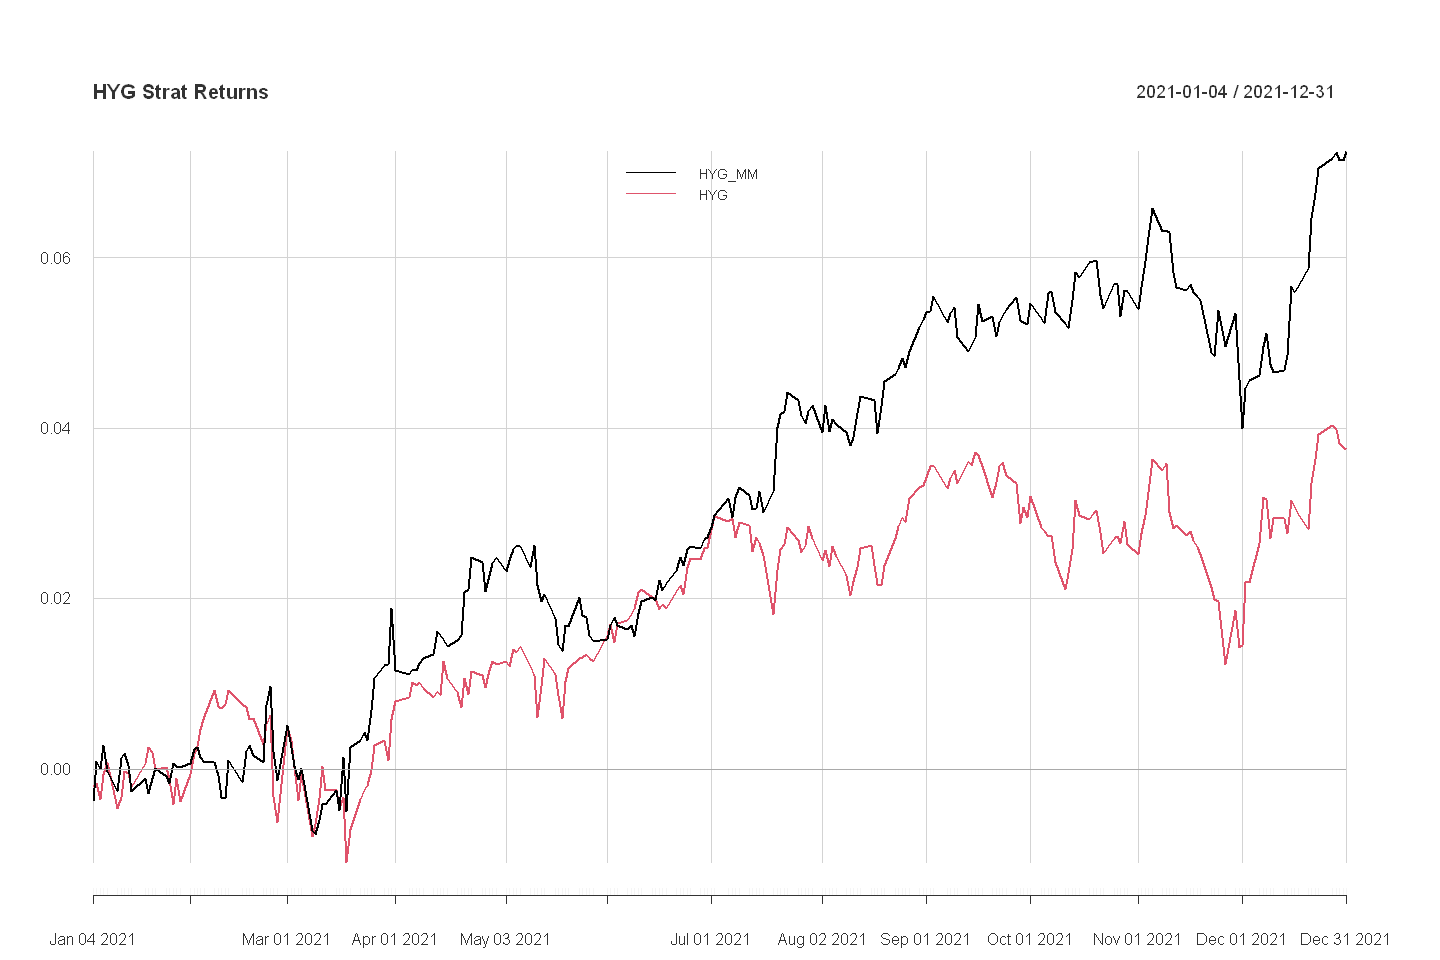



Table: Performance Metrics of JNK Models

|                                         | JNK_MM|    JNK|
|:----------------------------------------|------:|------:|
|Cumulative Return                        | 0.0448| 0.0399|
|Calmar Ratio                             | 1.1840| 1.6309|
|Annualized StdDev Sharpe (Rf=0%, p=95%): | 1.1011| 1.0240|
|Sortino Ratio (MAR = 0%)                 | 0.1041| 0.0933|
|Worst Drawdown                           | 0.0378| 0.0245|

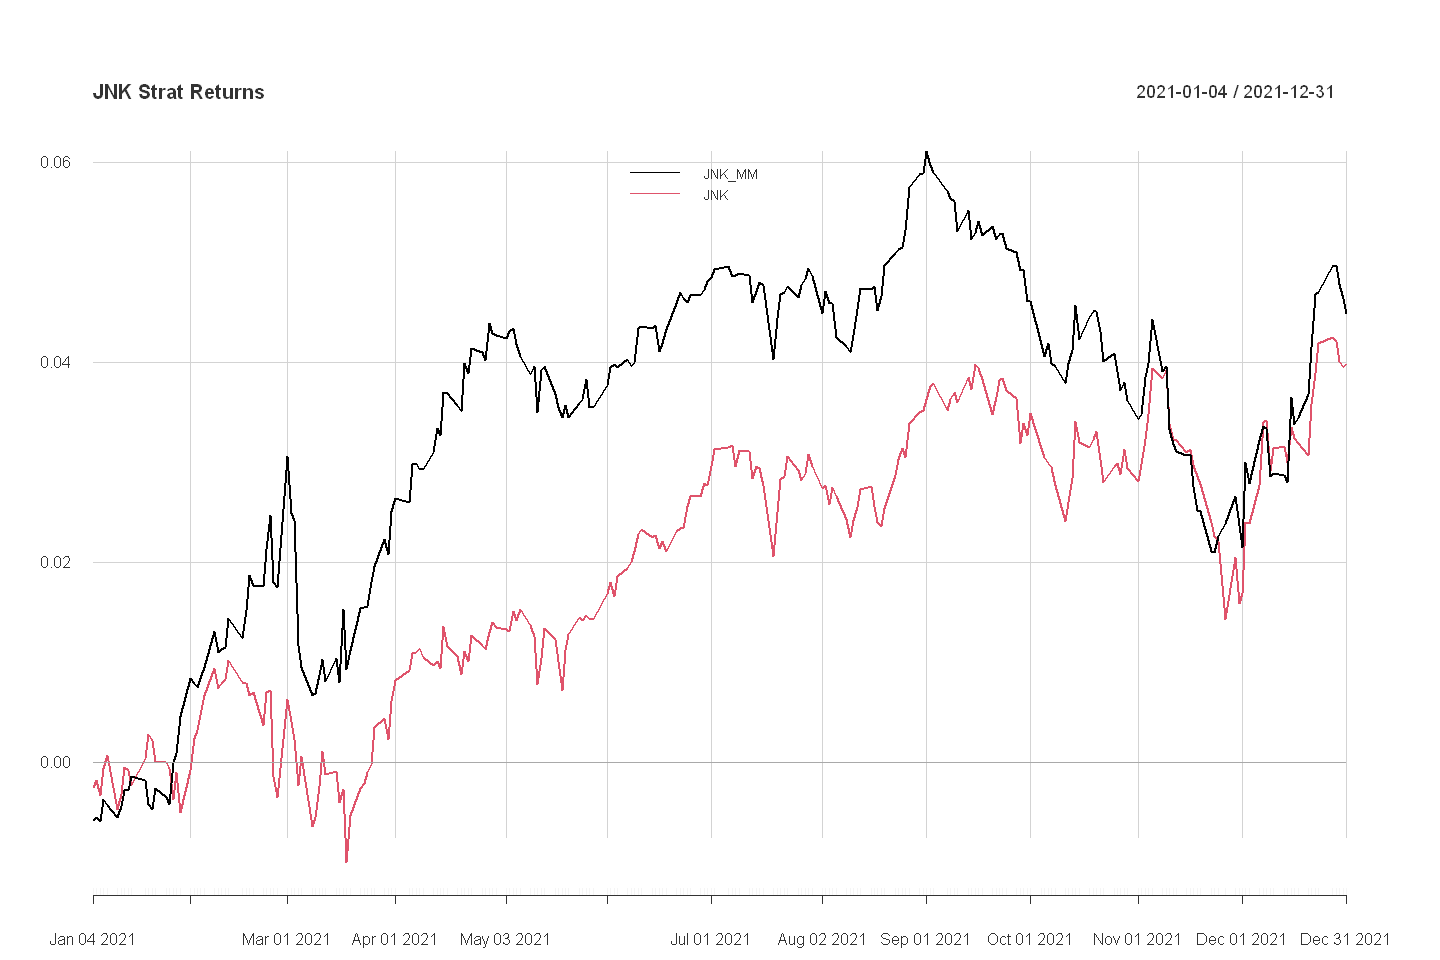



Table: Performance Metrics of BKLN Models

|                                         | BKLN_MM|   BKLN|
|:----------------------------------------|-------:|------:|
|Cumulative Return                        |  0.0307| 0.0232|
|Calmar Ratio                             |  2.6224| 1.6365|
|Annualized StdDev Sharpe (Rf=0%, p=95%): |  1.6297| 1.0486|
|Sortino Ratio (MAR = 0%)                 |  0.1589| 0.0953|
|Worst Drawdown                           |  0.0117| 0.0142|

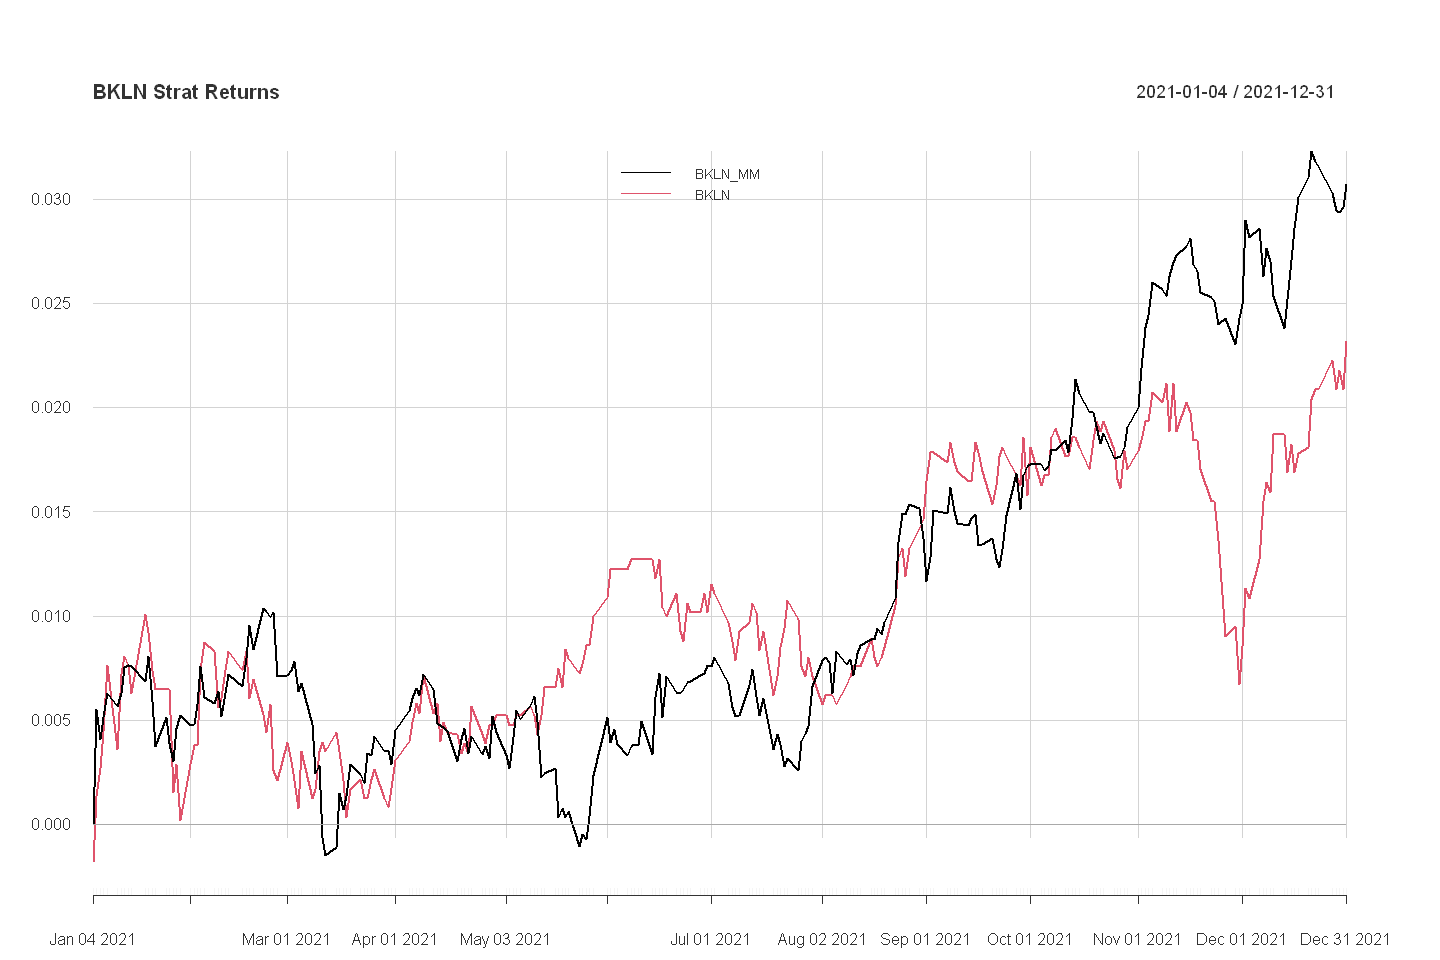



Table: Performance Metrics of SRLN Models

|                                         | SRLN_MM|   SRLN|
|:----------------------------------------|-------:|------:|
|Cumulative Return                        | -0.0539| 0.0448|
|Calmar Ratio                             | -0.9632| 3.4328|
|Annualized StdDev Sharpe (Rf=0%, p=95%): | -2.5350| 2.4198|
|Sortino Ratio (MAR = 0%)                 | -0.1956| 0.2275|
|Worst Drawdown                           |  0.0560| 0.0131|

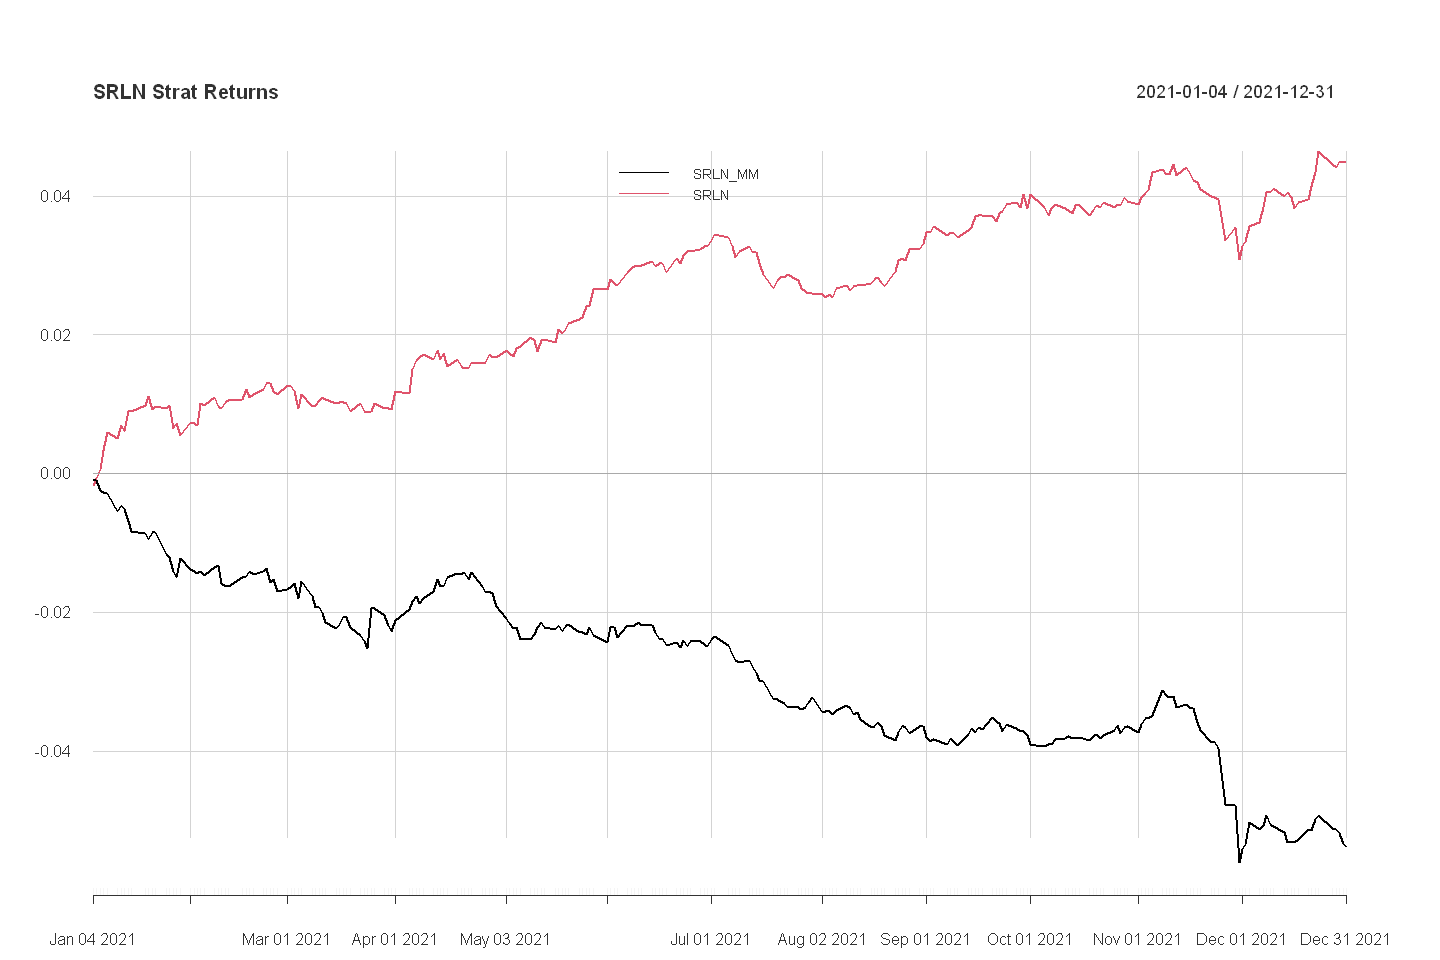



Table: Performance Metrics of PFF Models

|                                         | PFF_MM|    PFF|
|:----------------------------------------|------:|------:|
|Cumulative Return                        | 0.0705| 0.0714|
|Calmar Ratio                             | 1.3885| 2.2649|
|Annualized StdDev Sharpe (Rf=0%, p=95%): | 0.9932| 1.1197|
|Sortino Ratio (MAR = 0%)                 | 0.0915| 0.1016|
|Worst Drawdown                           | 0.0508| 0.0315|

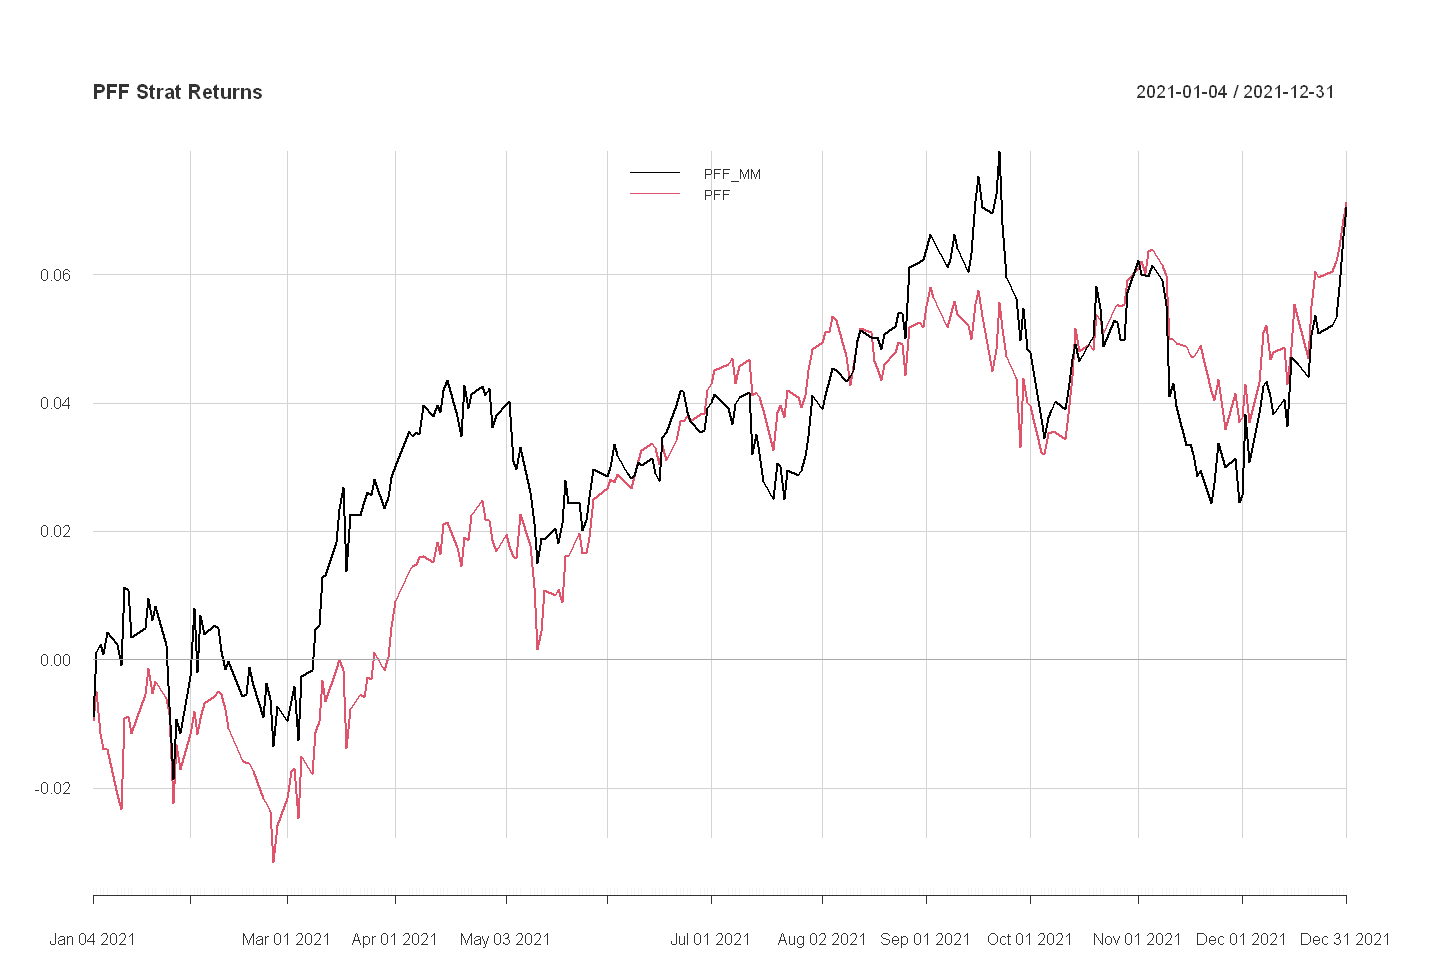



Table: Performance Metrics of PGX Models

|                                         |  PGX_MM|    PGX|
|:----------------------------------------|-------:|------:|
|Cumulative Return                        |  0.2247| 0.0315|
|Calmar Ratio                             | 13.4913| 0.7645|
|Annualized StdDev Sharpe (Rf=0%, p=95%): |  4.6116| 0.5635|
|Sortino Ratio (MAR = 0%)                 |  0.5513| 0.0516|
|Worst Drawdown                           |  0.0167| 0.0412|

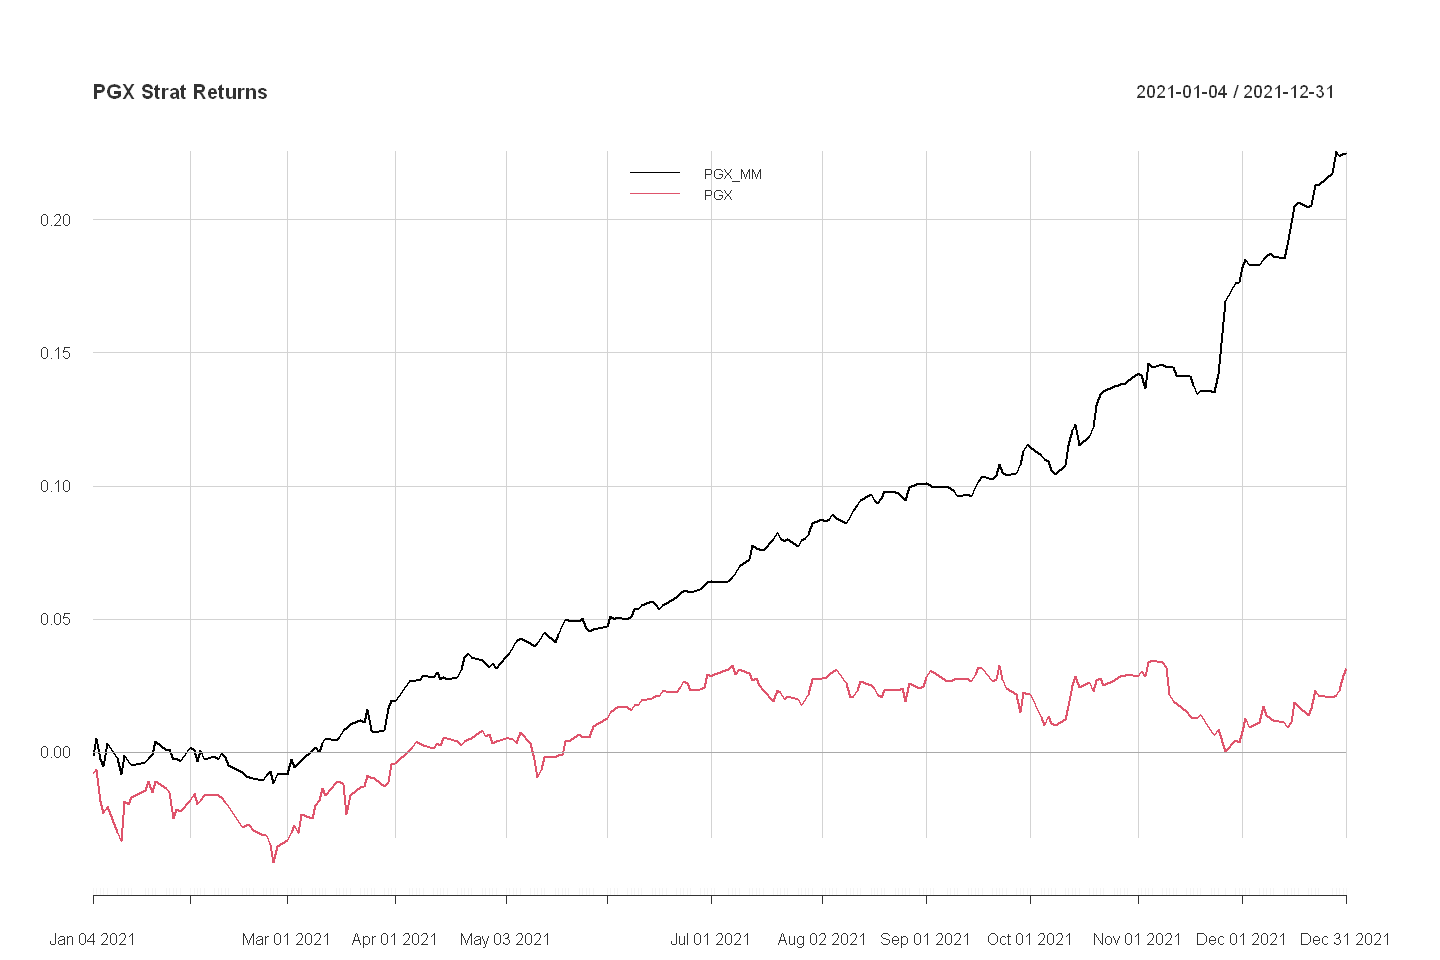



Table: Performance Metrics of SPHY Models

|                                         | SPHY_MM|   SPHY|
|:----------------------------------------|-------:|------:|
|Cumulative Return                        | -0.0591| 0.0560|
|Calmar Ratio                             | -0.9850| 2.3769|
|Annualized StdDev Sharpe (Rf=0%, p=95%): | -2.6719| 1.5089|
|Sortino Ratio (MAR = 0%)                 | -0.2199| 0.1366|
|Worst Drawdown                           |  0.0600| 0.0236|

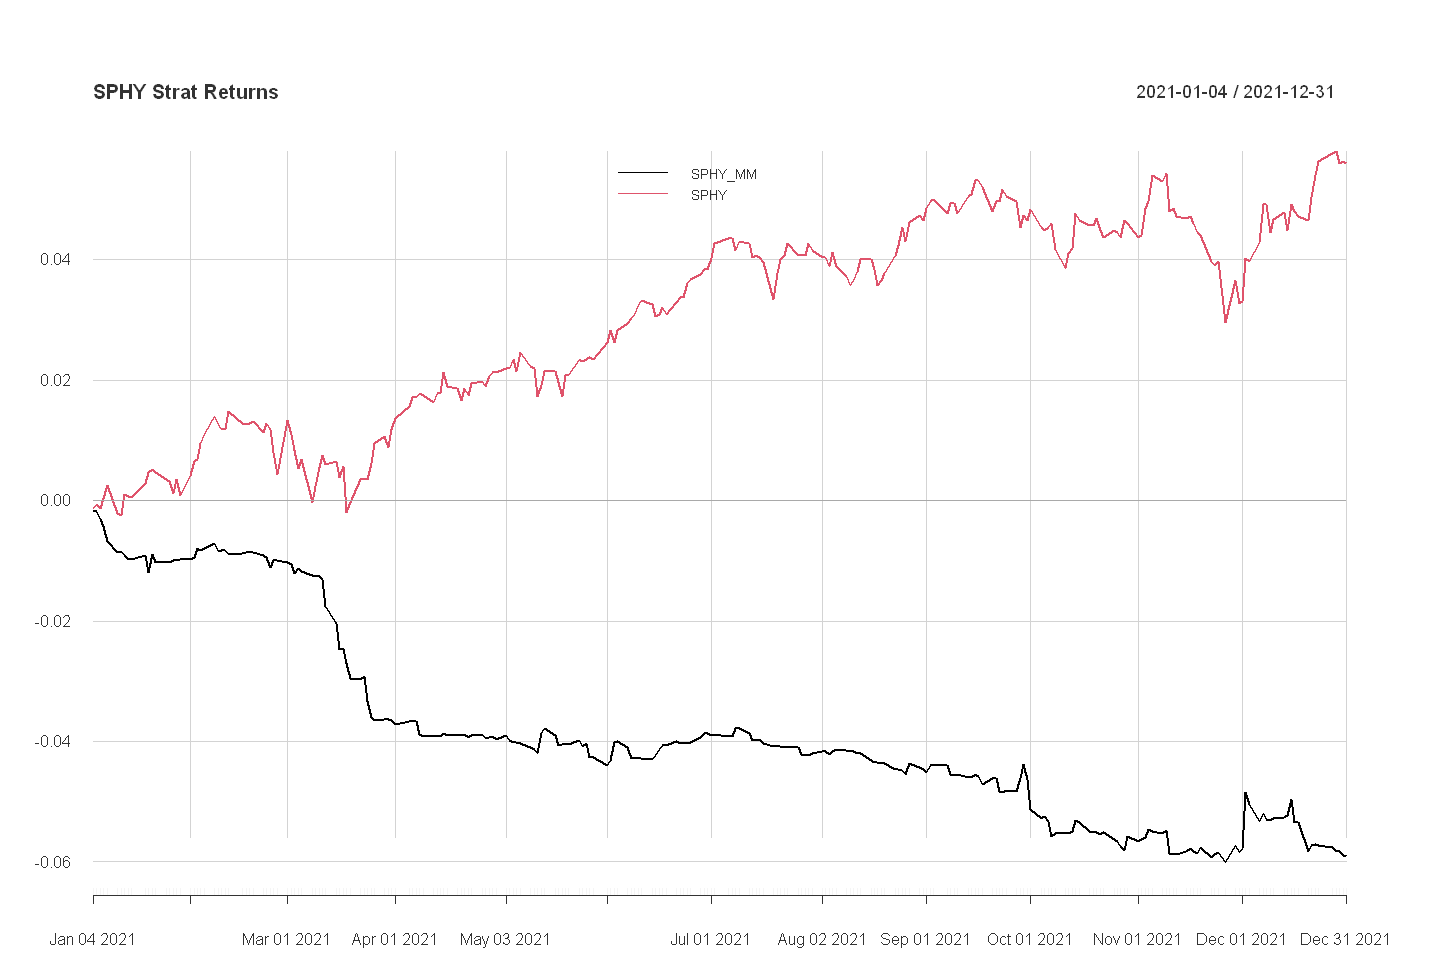

In [10]:
chart.CumReturns(hyg.xts, main='HYG Strat Returns',legend.loc = 'top')
hyg.performance.stats %>% 
  mutate_if(is.numeric,round,4) %>%
  kable(caption='Performance Metrics of HYG Models')

chart.CumReturns(jnk.xts, main='JNK Strat Returns',legend.loc = 'top')
jnk.performance.stats %>% 
  mutate_if(is.numeric,round,4) %>%
  kable(caption='Performance Metrics of JNK Models')

chart.CumReturns(bkln.xts, main='BKLN Strat Returns',legend.loc = 'top')
bkln.performance.stats %>% 
  mutate_if(is.numeric,round,4) %>%
  kable(caption='Performance Metrics of BKLN Models')

chart.CumReturns(srln.xts, main='SRLN Strat Returns',legend.loc = 'top')
srln.performance.stats %>% 
  mutate_if(is.numeric,round,4) %>%
  kable(caption='Performance Metrics of SRLN Models')

chart.CumReturns(pff.xts, main='PFF Strat Returns',legend.loc = 'top')
pff.performance.stats %>% 
  mutate_if(is.numeric,round,4) %>%
  kable(caption='Performance Metrics of PFF Models')


chart.CumReturns(pgx.xts, main='PGX Strat Returns',legend.loc = 'top')
pgx.performance.stats %>% 
  mutate_if(is.numeric,round,4) %>%
  kable(caption='Performance Metrics of PGX Models')


chart.CumReturns(sphy.xts, main='SPHY Strat Returns',legend.loc = 'top')
sphy.performance.stats %>% 
  mutate_if(is.numeric,round,4) %>%
  kable(caption='Performance Metrics of SPHY Models')


## Simple Strategy Backtest

  * Benchmark is equal-weighted ETFs (rebalanced every 5 minutes)

  * M-Strategy is equal-weighted ETFs based on M-estimate regression models (if predicted return > 0, take position, else no position)

  * M-Strategy is equal-weighted ETFs based on MM-estimate regression models (if predicted return > 0, take position, else no position)

In [11]:
mm.rtns <- merge.xts(hyg.strat.rtns$HYG_MM,jnk.strat.rtns$JNK_MM, bkln.strat.rtns$BKLN_MM,
          srln.strat.rtns$SRLN_MM, pff.strat.rtns$PFF_MM, pgx.strat.rtns$PGX_MM, sphy.strat.rtns$SPHY_MM, fill = 0)

wgts <- rep(1/ncol(mm.rtns),ncol(mm.rtns))

mm.strat.rtn <- matrix(mm.rtns %*% wgts, dimnames=list(index(mm.rtns),c('MM.strategy')))
mm.xts <- xts(mm.strat.rtn, order.by = index(mm.rtns))

bm.rtns <- Return.calculate(etf.xts, method = 'discrete')
benchmark.rtn <- matrix(bm.rtns %*% wgts, dimnames=list(index(bm.rtns),c('benchmark'))) 
bm.xts <- xts(benchmark.rtn, order.by = index(bm.rtns))

mm.daily.rtns <- apply.daily(mm.xts,Return.cumulative)
index(mm.daily.rtns) <- as.Date(index(mm.daily.rtns))



Table: Downside Ratios

|                         | benchmark| MM.strategy|
|:------------------------|---------:|-----------:|
|daily downside risk      |    0.0015|      0.0009|
|Annualised downside risk |    0.0233|      0.0137|
|Downside potential       |    0.0007|      0.0004|
|Omega                    |    1.2474|      1.4001|
|Sortino ratio            |    0.1170|      0.1997|
|Upside potential         |    0.0009|      0.0006|
|Upside potential ratio   |    0.7164|      0.7732|
|Omega-sharpe ratio       |    0.2474|      0.4001|



Table: Downside Risk

|                              | benchmark| MM.strategy|
|:-----------------------------|---------:|-----------:|
|Semi Deviation                |    0.0016|      0.0009|
|Gain Deviation                |    0.0013|      0.0010|
|Loss Deviation                |    0.0016|      0.0008|
|Downside Deviation (MAR=210%) |    0.0084|      0.0083|
|Downside Deviation (Rf=0%)    |    0.0015|      0.0009|
|Downside Deviation (0%)       |    0.0015|      0.0009|
|Maximum Drawdown              |    0.0216|      0.0130|
|Historical VaR (95%)          |   -0.0038|     -0.0018|
|Historical ES (95%)           |   -0.0051|     -0.0028|
|Modified VaR (95%)            |   -0.0035|     -0.0019|
|Modified ES (95%)             |   -0.0051|     -0.0025|



Table: Return Distributions

|                       | benchmark| MM.strategy|
|:----------------------|---------:|-----------:|
|daily  Std Dev         |    0.0021|      0.0014|
|Skewness               |   -0.4811|      0.3062|
|Kurtosis               |    4.2392|      4.8620|
|Excess kurtosis        |    1.2392|      1.8620|
|Sample skewness        |   -0.4868|      0.3099|
|Sample excess kurtosis |    1.2883|      1.9236|



Table: Up-Down Ratios

|                         | Up Capture| Down Capture| Up Number| Down Number| Up Percent| Down Percent|
|:------------------------|----------:|------------:|---------:|-----------:|----------:|------------:|
|MM.strategy to benchmark |     0.5595|       0.4507|    0.7986|      0.6814|     0.1799|       0.7611|

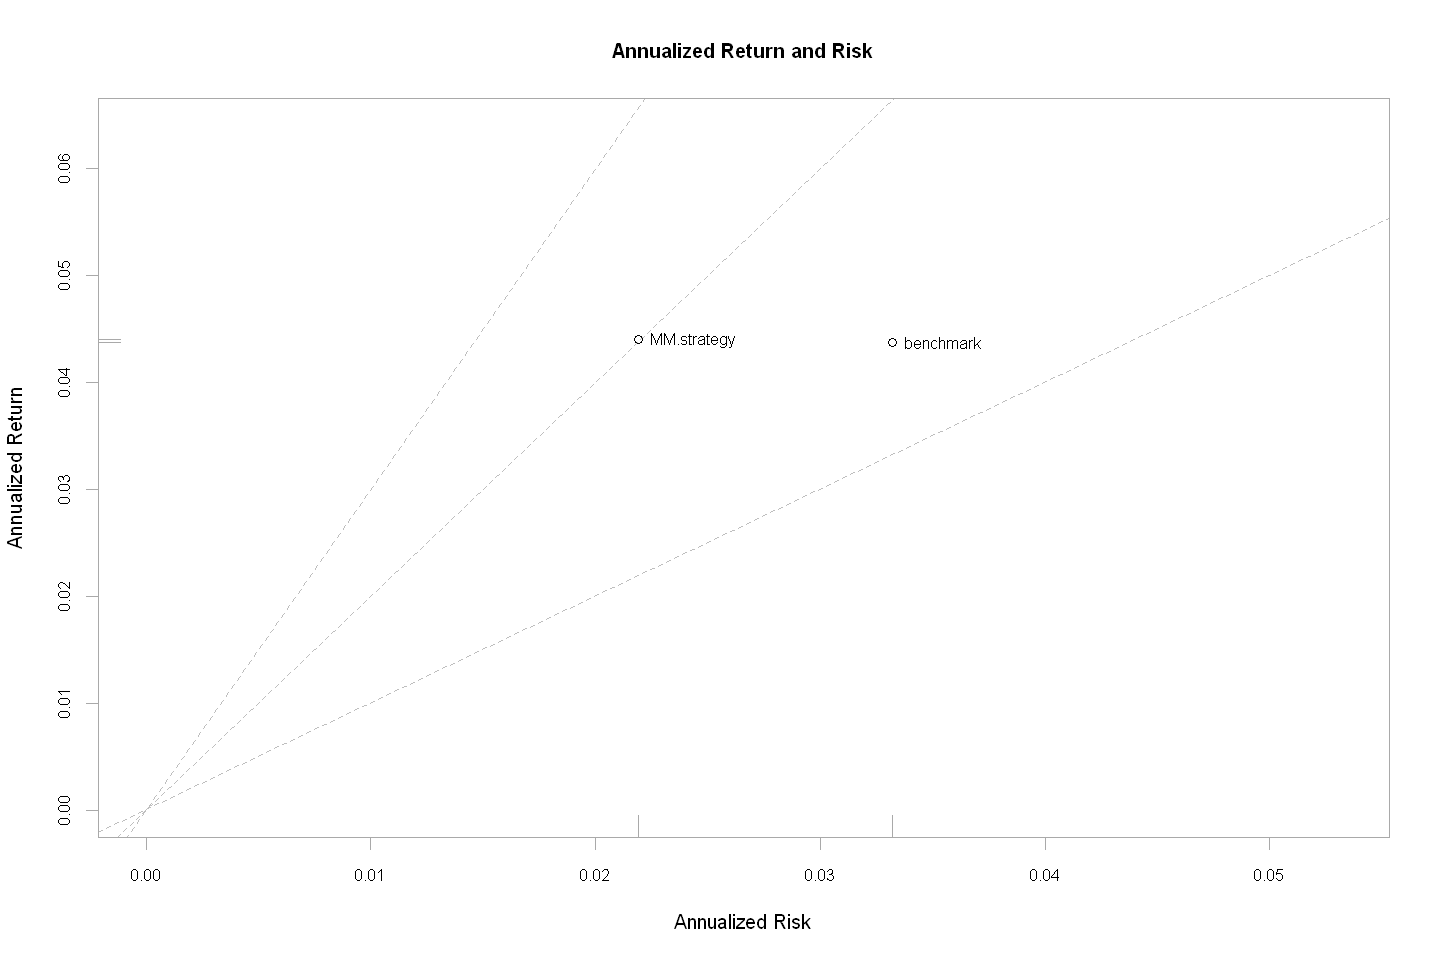

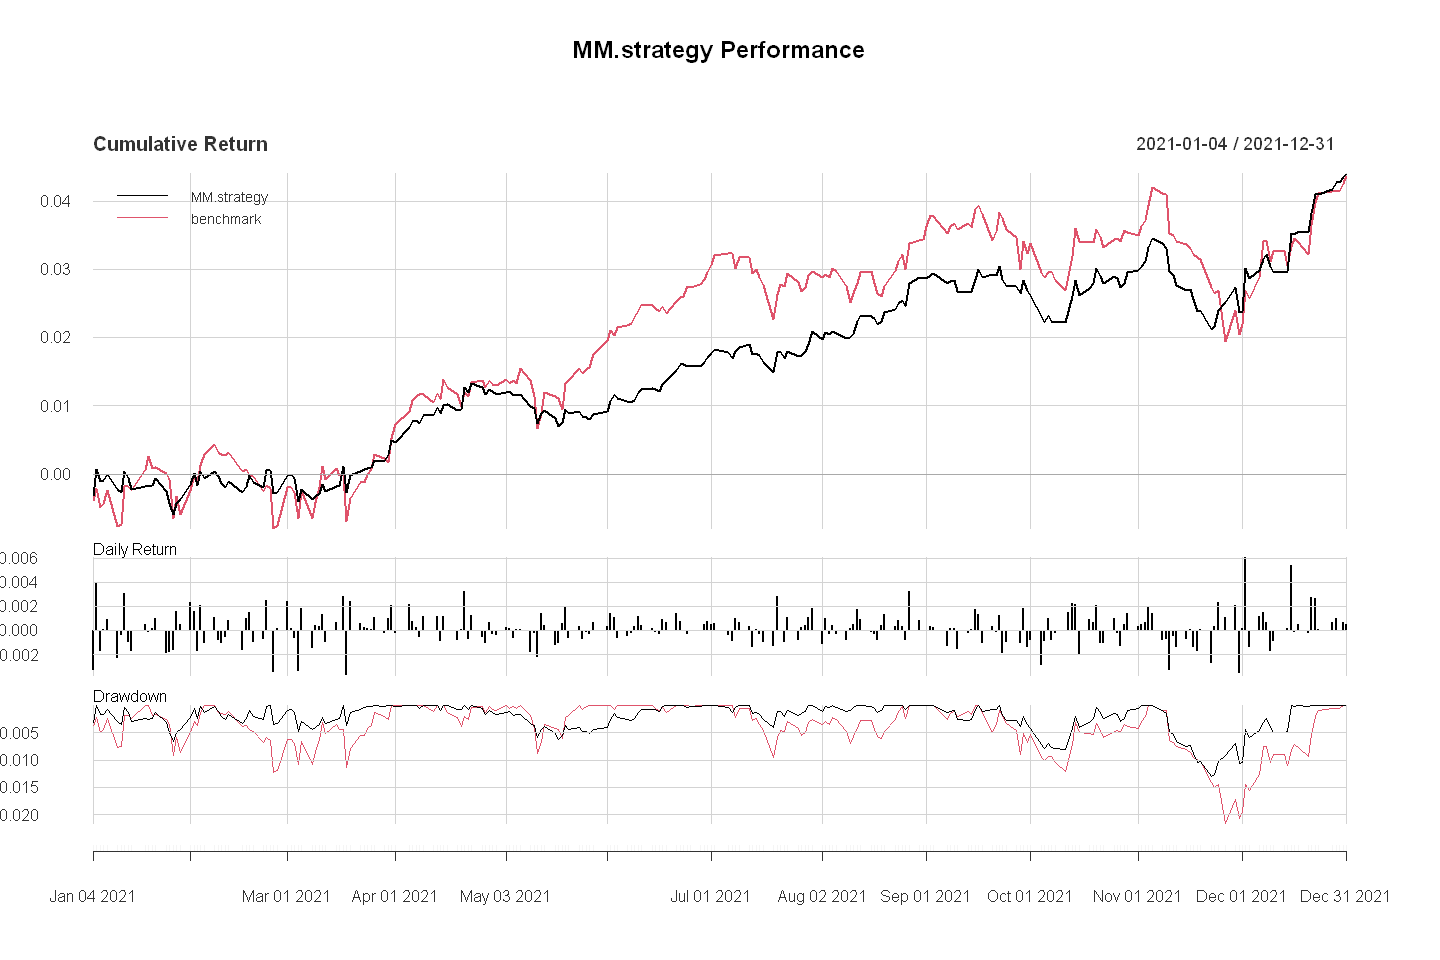

In [12]:
strat.xts <- merge.xts(bm.xts, mm.daily.rtns)[-1,] # drop first row due to NAs

CumRtn <- Return.cumulative(strat.xts)
calmar <- CalmarRatio(strat.xts, scale = 252)
sharpe <- SharpeRatio(strat.xts, scale = 252, annualize = TRUE, FUN = 'StdDev')
sortino <- SortinoRatio(strat.xts, scale = 252)
max.drawdown <- maxDrawdown(strat.xts)
strat.performance.stats <- rbind.data.frame(CumRtn, calmar, sharpe, sortino, max.drawdown)

kable(table.DownsideRiskRatio(strat.xts),caption = 'Downside Ratios')
kable(table.DownsideRisk(strat.xts),caption = 'Downside Risk')
kable(table.Distributions(strat.xts),caption = 'Return Distributions')
kable(table.UpDownRatios(strat.xts[,-1], Rb = strat.xts$benchmark),caption = 'Up-Down Ratios')
chart.RiskReturnScatter(strat.xts)

charts.PerformanceSummary(strat.xts[,c('MM.strategy','benchmark')])



Table: Performance Metrics of Strategies

|                                         | benchmark| MM.strategy|
|:----------------------------------------|---------:|-----------:|
|Cumulative Return                        |    0.0437|      0.0440|
|Calmar Ratio                             |    2.0258|      3.3963|
|Annualized StdDev Sharpe (Rf=0%, p=95%): |    1.3161|      2.0066|
|Sortino Ratio (MAR = 0%)                 |    0.1170|      0.1997|
|Worst Drawdown                           |    0.0216|      0.0130|

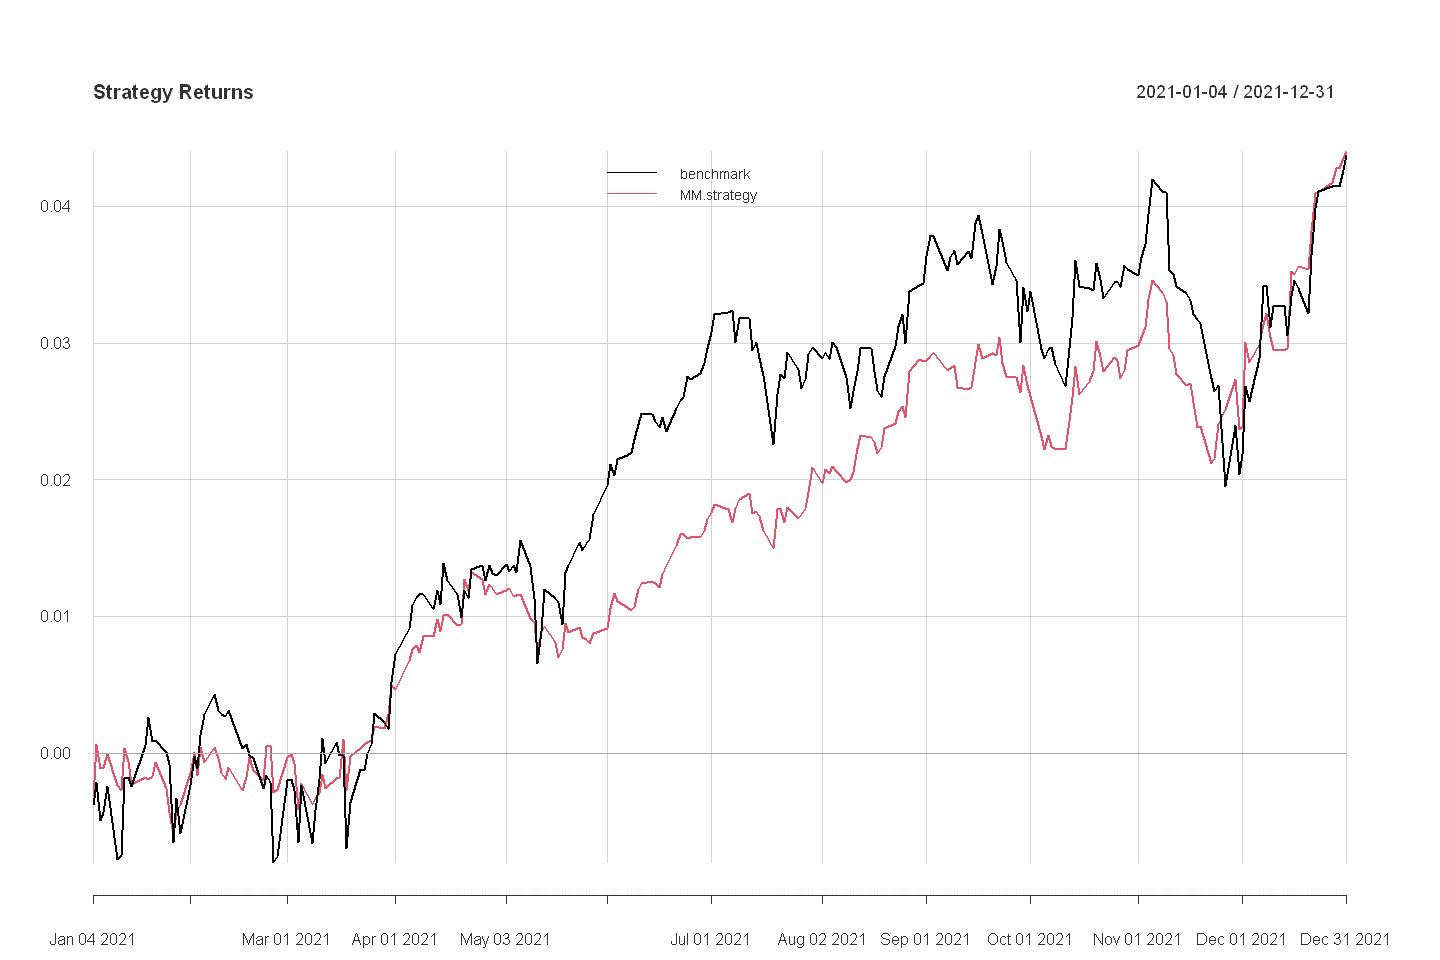

In [13]:
chart.CumReturns(strat.xts,main='Strategy Returns',legend.loc = 'top')

strat.performance.stats %>% 
  mutate_if(is.numeric,round,4) %>%
  kable(caption='Performance Metrics of Strategies')